In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import xgboost as xg
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
__ROOT_PATH__ = Path(__name__).resolve().parent.parent

datasets_path = __ROOT_PATH__ / "data"

In [3]:
dataframes = dict()

for file in os.listdir(datasets_path):
    if file.lower().endswith(".csv"):
        dataset_file = pd.read_csv(datasets_path / file, decimal=".")

        file_name = file.split(".")[0]
        dataframes[file_name] = dataset_file

    else:
        print("File does not correspond to the specified extension (.csv)")

File does not correspond to the specified extension (.csv)


In [4]:
dataframes["iron_ore"] = dataframes.pop("Iron ore fines 62% Fe CFR Futures Historical Data")
dataframes["hot_rolled_coil"] = dataframes.pop("US Midwest Domestic Hot-Rolled Coil Steel Futures Historical Data")
dataframes["usd_index"] = dataframes.pop("US Dollar Index Futures Historical Data")
dataframes["steel_scrap"] = dataframes.pop("Steel Scrap Futures Historical Data")

In [5]:
def stock_market_treatment(dictionary:dict):
    for key, dataset in dictionary.items():
        if not str(key).endswith("_br"):
            dictionary[key] = dataset.loc[:,["Date", "Price"]]
            dictionary[key].columns = ["date", "price"]

            # Transforming date into datetime type
            if "/" in dictionary[key]["date"][0]:
                dictionary[key]["date"] = pd.to_datetime(dictionary[key]["date"])
            else:
                dictionary[key]["date"] = [datetime.strptime(date, "%b %y").strftime("01/%m/%Y") for date in dictionary[key]["date"]]
            # Filtering only the columns date and price to the dataset
            dictionary[key] = dictionary[key][
                ["date", "price"]
                ][::-1].reset_index(drop=True)

stock_market_treatment(dataframes)

In [6]:
for key, _ in dataframes.items():
    print(f"\n{key}")
    print(dataframes[key].dtypes)


iron_ore
date     datetime64[ns]
price           float64
dtype: object

hot_rolled_coil
date     datetime64[ns]
price            object
dtype: object

usd_index
date      object
price    float64
dtype: object

steel_scrap
date     datetime64[ns]
price           float64
dtype: object


In [7]:
for key, _ in dataframes.items():
    if dataframes[key]["price"].dtypes == object:
        dataframes[key]["price"] = [
            value.replace(",", "") 
            for value in dataframes[key]["price"]
            ]
        dataframes[key]["price"] = pd.to_numeric(dataframes[key]["price"])

In [8]:
df_completo = pd.DataFrame()
for key, _ in dataframes.items():
    dataframes[key].columns = ["date", f"price_{key}"]
    df_completo = pd.concat([df_completo, dataframes[key]], axis=1)

df_completo = df_completo.iloc[:, [0, 1, 5, 7, 3]]
df_completo.head()

,date,price_iron_ore,price_usd_index,price_steel_scrap,price_hot_rolled_coil
0,2019-01-01,76.03,94.794,289.30,694.0
1,2019-02-01,87.33,95.558,320.44,714.0
2,2019-03-01,85.70,96.330,320.74,697.0
3,2019-04-01,93.24,96.661,309.95,654.0
4,2019-05-01,98.76,97.136,298.50,584.0


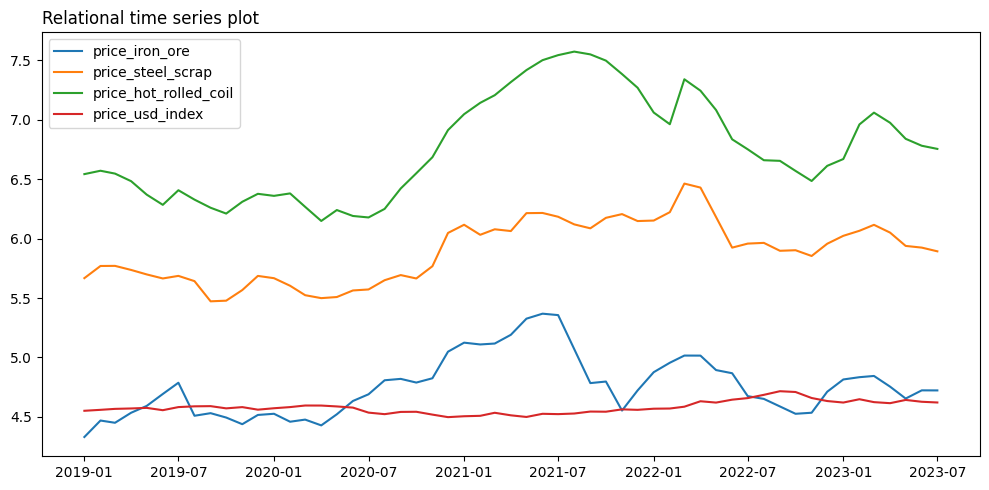

In [9]:
date = df_completo["date"]
plt.figure(figsize=(10, 5))
plt.plot(date, np.log(df_completo["price_iron_ore"]))
plt.plot(date, np.log(df_completo["price_steel_scrap"]))
plt.plot(date, np.log(df_completo["price_hot_rolled_coil"]))
plt.plot(date, np.log(df_completo["price_usd_index"]))
plt.title("Relational time series plot", loc="left")
plt.legend(["price_iron_ore", "price_steel_scrap", "price_hot_rolled_coil", "price_usd_index"])
plt.tight_layout()
plt.show()

## Getting Correlations

In [10]:
def correlation_comprehension(dataset, column, shift_value):
    dataset_corr = dataset.copy()
    dataset_corr[column] =  dataset_corr[column].shift(-shift_value)
    correlation = dataset_corr.drop(["date"], axis=1).corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation, annot=True)
    plt.title(f"Shift {shift_value} time correlation", loc="left")
    plt.tight_layout()
    plt.show()

In [11]:
def get_correlations(dataset, column, range_shift:range):
    output_list = list()

    for i in range_shift:
        dataset_new = dataset.copy()
        dataset_new[column] = dataset_new[column].shift(-i)
        correl = dataset_new.drop("date", axis=1).corr()[column]
        output_list.append(
            [i, "price_hot_rolled_coil" , correl[0], correl[1], correl[2]]
            )

    cols = [
        "lag", "target_variable", 
        "price_iron_ore", "price_usd_index", 
        "price_steel_scrap"
        ]
    return pd.DataFrame(data=output_list, columns=cols)

In [12]:
def get_best_lags(dataset_correlation, columns):
    dict_max = dict()

    for col in columns:
        dict_max[col] = [np.max(abs(dataset_correlation[col]))]

    return dict_max

In [13]:
range_shift = range(0, 25)

df_correlations = get_correlations(df_completo, "price_hot_rolled_coil", range_shift)
best_lags = get_best_lags(df_correlations, ["price_iron_ore", "price_usd_index", "price_steel_scrap"])

In [14]:
best_lags

{'price_iron_ore': [0.8642859262985076],
 'price_usd_index': [0.7497956452146401],
 'price_steel_scrap': [0.8449728784345002]}

In [15]:
df_correlations

,lag,target_variable,price_iron_ore,price_usd_index,price_steel_scrap
0,0,price_hot_rolled_coil,0.737264,-0.299399,0.844973
1,1,price_hot_rolled_coil,0.822807,-0.386761,0.806217
2,2,price_hot_rolled_coil,0.864286,-0.447274,0.724753
3,3,price_hot_rolled_coil,0.850553,-0.474212,0.633265
4,4,price_hot_rolled_coil,0.795324,-0.468610,0.561682
5,5,price_hot_rolled_coil,0.736374,-0.455326,0.483899
6,6,price_hot_rolled_coil,0.653127,-0.439704,0.377521
7,7,price_hot_rolled_coil,0.590028,-0.429660,0.267875
8,8,price_hot_rolled_coil,0.554203,-0.410402,0.169559
9,9,price_hot_rolled_coil,0.505585,-0.385552,0.095593


In [24]:
# use a dataframe without target variable
def check_vif(dataframe:pd.DataFrame):
    vif = pd.DataFrame()
    vif["VIF factor"] = [
        variance_inflation_factor(dataframe.values, col) 
        for col in range(dataframe.shape[1])
        ]
    vif["Features"] = dataframe.columns

    return vif

In [25]:
X = df_completo.drop(["price_hot_rolled_coil", "date"], axis=1)
y = df_completo["price_hot_rolled_coil"]

In [26]:
vif_dataframe = check_vif(X)
vif_dataframe

,VIF factor,Features
0,24.639721,price_iron_ore
1,16.083711,price_usd_index
2,31.898522,price_steel_scrap


The features have pretty different VIF factor. It means that each feature explains different variances in the dataset.\
We can go further with all three variables.

In [ ]:
slicing = int(len(df_completo)) * 0.8
X_train = X.loc[:slicing:, :]
X_test = X.loc[slicing:, :]

y_train = y.loc[:slicing]
y_test = y.loc[slicing:]

In [ ]:
def checking_results(y_pred, y_true):
    result_mae = round(mean_absolute_error(y_pred, y_true), ndigits=3)
    result_mse = round(mean_squared_error(y_pred, y_true), ndigits=3)

    print(f"Results of MAE: {result_mae}")
    print(f"Results of MSE: {result_mse}")

In [ ]:
datas = df_completo.loc[slicing:]["date"].values

In [ ]:
model_v1 = LinearRegression()
model_v1.fit(X_train, y_train)

LinearRegression()

In [ ]:
results_v1 = model_v1.predict(X_test)

In [ ]:
def plotting_results(dates, y_true, y_pred, model, version):
    plt.figure(figsize=(10,4))
    plt.plot(dates, y_true)
    plt.plot(dates, y_pred)
    plt.title(f"Testing Results - {model} {version}", loc="left")
    plt.tight_layout()
    plt.show()

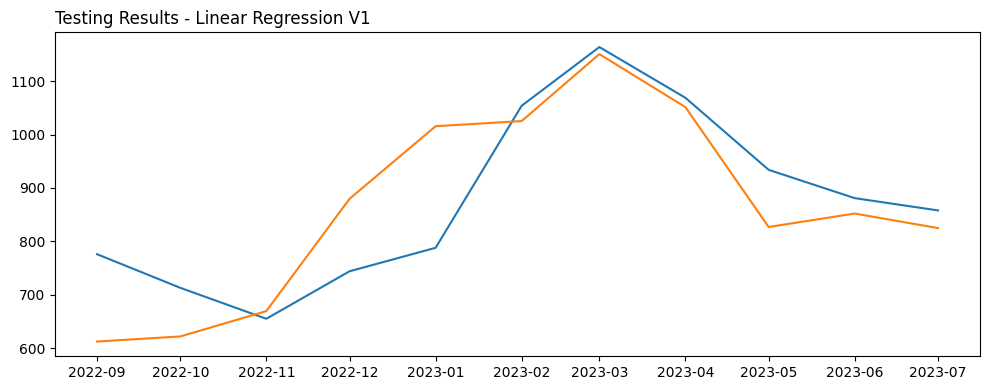

Results of MAE: 78.269
Results of MSE: 10933.404


In [ ]:
plotting_results(datas, y_test, results_v1, "Linear Regression", "V1")
checking_results(y_test, results_v1)

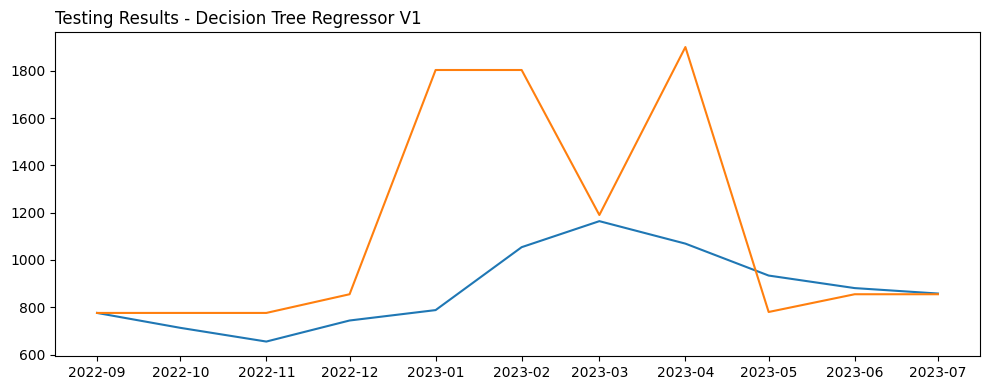

Results of MAE: 281.727
Results of MSE: 212526.818


In [ ]:
model_decisiontree_v1 = DecisionTreeRegressor()
model_decisiontree_v1.fit(X_train, y_train)
decisiontree_results_v1 = model_decisiontree_v1.predict(X_test)

plotting_results(datas, y_test, decisiontree_results_v1, "Decision Tree Regressor", "V1")
checking_results(y_test, decisiontree_results_v1)

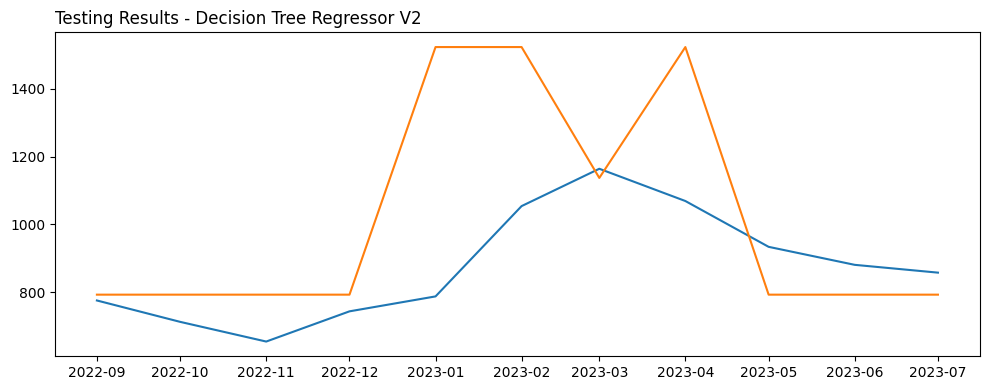

Results of MAE: 205.604
Results of MSE: 93214.094


In [ ]:
model_decisiontree_v2 = DecisionTreeRegressor(max_depth=5, max_leaf_nodes=8)
model_decisiontree_v2.fit(X_train, y_train)
decisiontree_results_v2 = model_decisiontree_v2.predict(X_test)

plotting_results(datas, y_test, decisiontree_results_v2, "Decision Tree Regressor", "V2")
checking_results(y_test, decisiontree_results_v2)

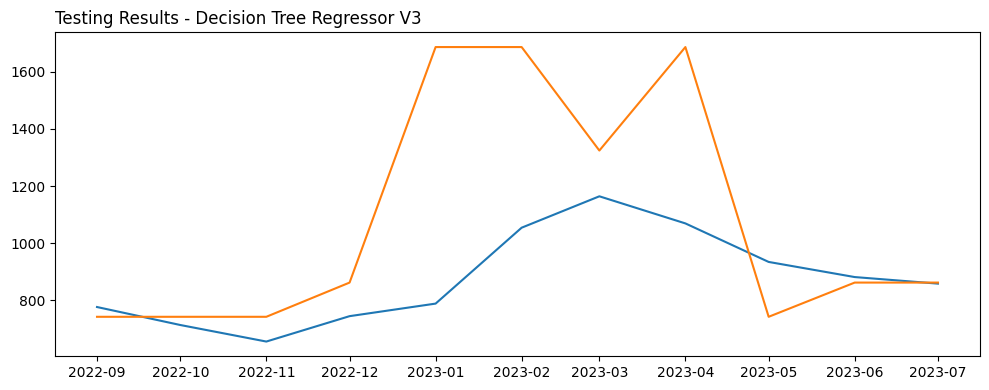

Results of MAE: 253.912
Results of MSE: 152477.128


In [ ]:
model_decisiontree_v3 = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=18)
model_decisiontree_v3.fit(X_train, y_train)
decisiontree_results_v3 = model_decisiontree_v3.predict(X_test)

plotting_results(datas, y_test, decisiontree_results_v3, "Decision Tree Regressor", "V3")
checking_results(y_test, decisiontree_results_v3)

[20:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


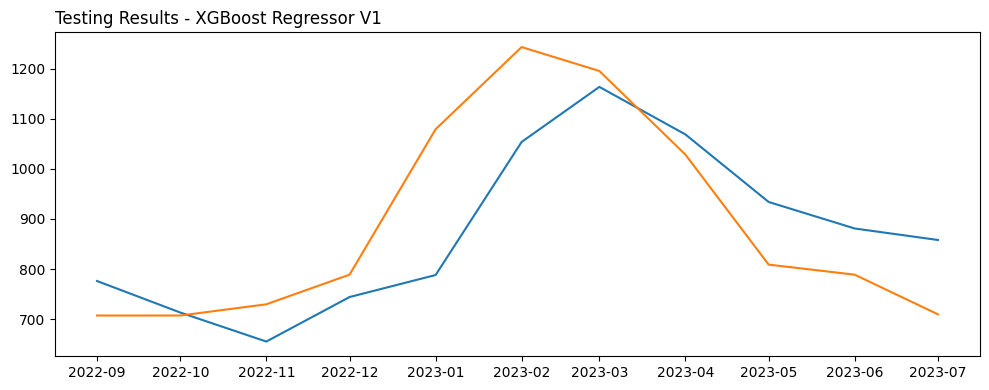

Results of MAE: 101.217
Results of MSE: 16557.174


In [ ]:
model_xgboost_v1 = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10)
model_xgboost_v1.fit(X_train, y_train)
xgboost_results_v1 = model_xgboost_v1.predict(X_test)

plotting_results(datas, y_test, xgboost_results_v1, "XGBoost Regressor", "V1")
checking_results(y_test, xgboost_results_v1)

Trying to make the prediction of logs. Bringing all data to the same "size"

In [ ]:
slicing = int(len(df_completo)) * 0.8
X_train_log = np.log(X.loc[:slicing:, :])
X_test_log = np.log(X.loc[slicing:, :])

y_train_log = np.log(y.loc[:slicing])
y_test_log = np.log(y.loc[slicing:])

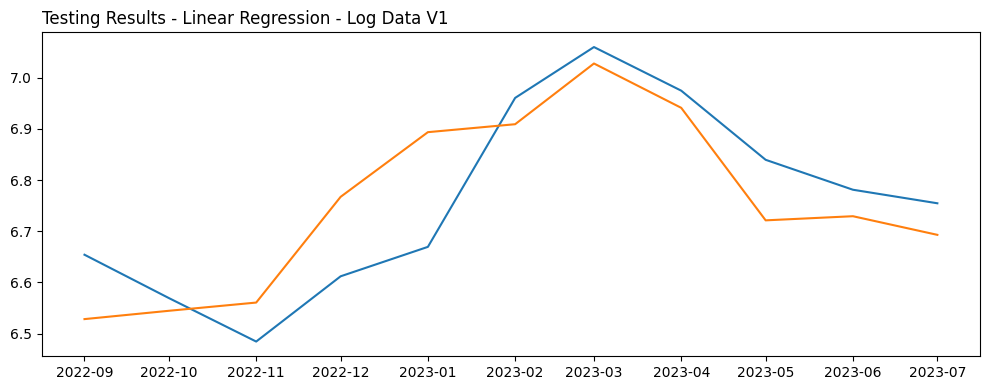

Results of MAE: 0.087
Results of MSE: 0.011


In [ ]:
model_v1_log = LinearRegression()
model_v1_log.fit(X_train_log, y_train_log)
results_v1_log = model_v1_log.predict(X_test_log)

plotting_results(datas, y_test_log, results_v1_log, "Linear Regression - Log Data", "V1")
checking_results(y_test_log, results_v1_log)

[20:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


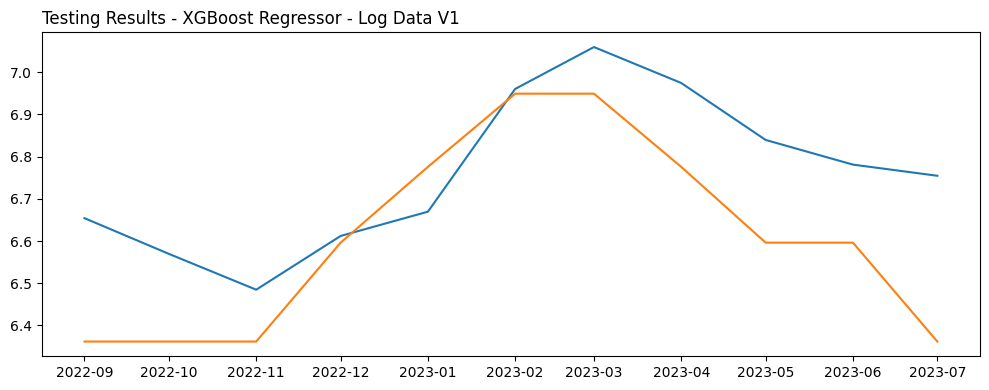

Results of MAE: 0.172
Results of MSE: 0.041


In [ ]:
model_xgboost_v1_log = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10)
model_xgboost_v1_log.fit(X_train_log, y_train_log)
xgboost_results_v1_log = model_xgboost_v1_log.predict(X_test_log)

plotting_results(datas, y_test_log, xgboost_results_v1_log, "XGBoost Regressor - Log Data", "V1")
checking_results(y_test_log, xgboost_results_v1_log)

At this point I haven't done any type of shifting.\
Now I'll try to make these tests making the shifts with some good correlation found upwards

In [ ]:
# making shifts
df_shift = df_completo.copy()
df_shift["price_iron_ore"] = X["price_iron_ore"].shift(+3)
df_shift["price_usd_index"] = X["price_usd_index"].shift(+23)
df_shift["price_steel_scrap"] = X["price_steel_scrap"].shift(+3)
df_shift.dropna(inplace=True)
df_shift.reset_index(inplace=True, drop=True)

In [ ]:
X_new = df_shift.drop(["price_hot_rolled_coil", "date"], axis=1)
y_new = df_shift["price_hot_rolled_coil"]

In [ ]:
maximum_lag = 3
slicing = len(df_shift) - maximum_lag
datas = df_shift.loc[slicing:]["date"].values

In [ ]:
X_train_new = X_new.loc[:slicing, :]
X_test_new = X_new.loc[slicing:, :]

In [ ]:
y_train_new = y_new.loc[:slicing]
y_test_new = y_new.loc[slicing:]

Applying Models to the values with "more correlated" lags found

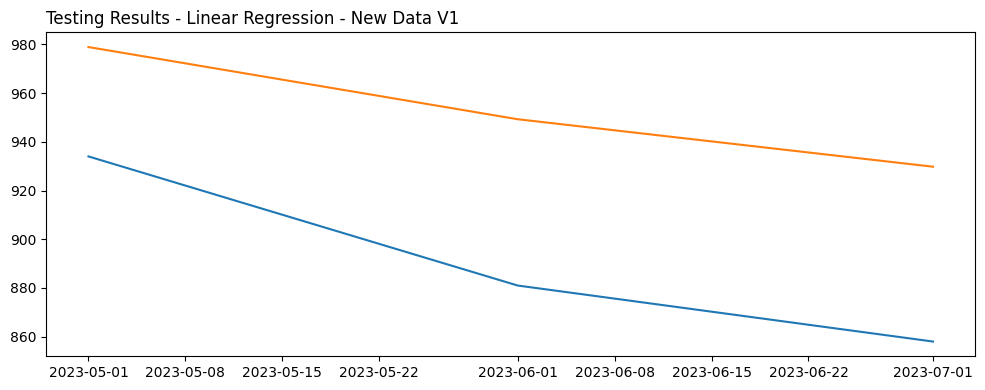

Results of MAE: 61.647
Results of MSE: 3942.613


In [ ]:
model_v1_new = LinearRegression()
model_v1_new.fit(X_train_new, y_train_new)
results_v1_new = model_v1_new.predict(X_test_new)

plotting_results(datas, y_test_new, results_v1_new, "Linear Regression - New Data", "V1")
checking_results(y_test_new, results_v1_new)

[20:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


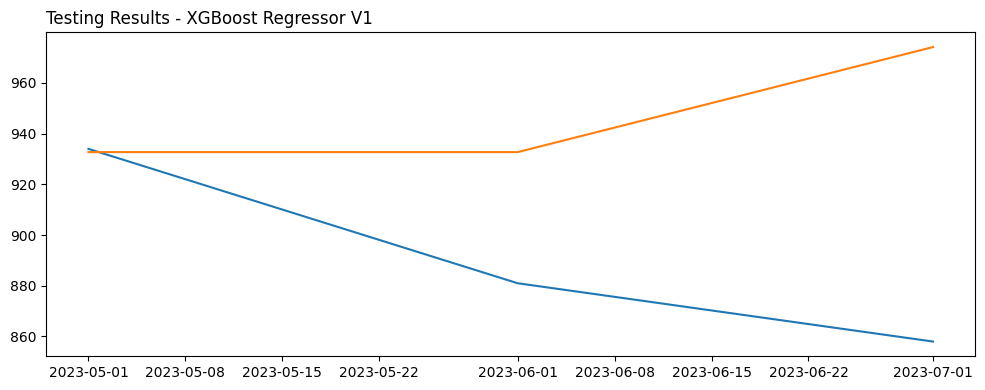

Results of MAE: 56.386
Results of MSE: 5389.676


In [ ]:
model_xgboost_v1_new = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10)
model_xgboost_v1_new.fit(X_train_new, y_train_new)
xgboost_results_v1_new = model_xgboost_v1_new.predict(X_test_new)

plotting_results(datas, y_test_new, xgboost_results_v1_new, "XGBoost Regressor", "V1")
checking_results(y_test_new, xgboost_results_v1_new)

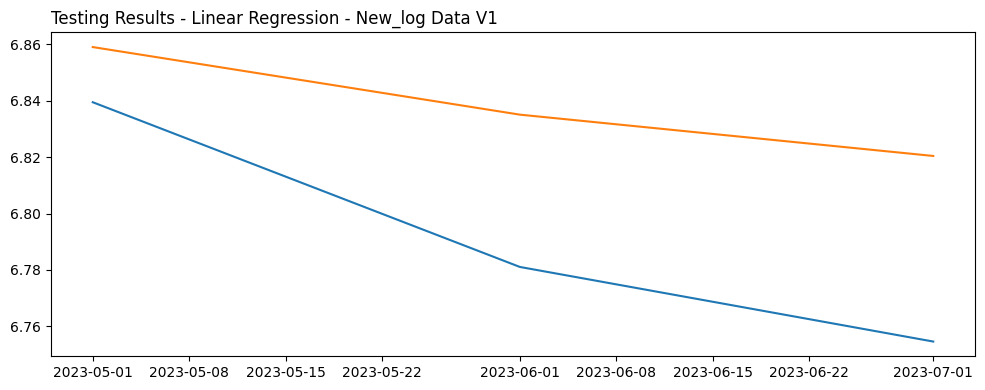

Results of MAE: 0.046
Results of MSE: 0.003


In [ ]:
model_v1_new_log = LinearRegression()
model_v1_new_log.fit(np.log(X_train_new), np.log(y_train_new))
results_v1_new_log = model_v1_new_log.predict(np.log(X_test_new))

plotting_results(datas, np.log(y_test_new), results_v1_new_log, "Linear Regression - New_log Data", "V1")
checking_results(np.log(y_test_new), results_v1_new_log)

[20:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


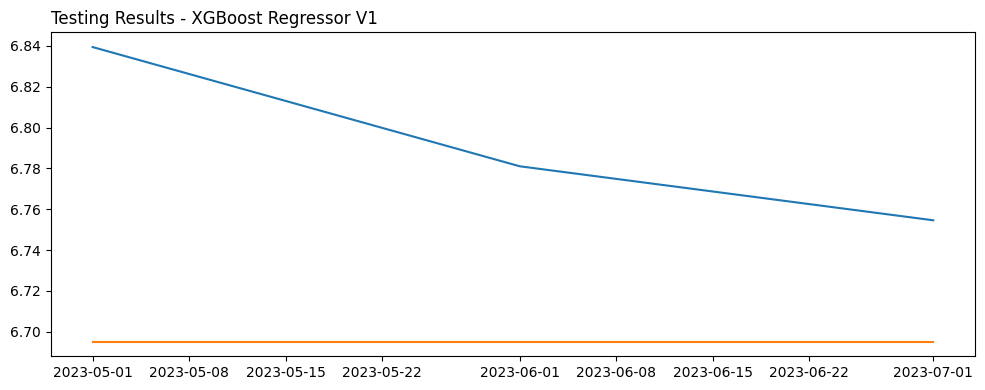

Results of MAE: 0.097
Results of MSE: 0.011


In [ ]:
model_xgboost_v1_new = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10)
model_xgboost_v1_new.fit(np.log(X_train_new), np.log(y_train_new))
xgboost_results_v1_new = model_xgboost_v1_new.predict(np.log(X_test_new))

plotting_results(datas, np.log(y_test_new), xgboost_results_v1_new, "XGBoost Regressor", "V1")
checking_results(np.log(y_test_new), xgboost_results_v1_new)

I'll proceed with the normal value models.\
Besides turning the values to log might achieve a more relational scale in the data\
in this case, bests models worked with the values itself.